In [25]:
import numpy as np
import scipy.stats as stats
from numpy import sqrt, exp
import scipy.optimize as opt
import matplotlib.pyplot as plt
# import numba
import math
import warnings

warnings.filterwarnings("ignore")  # 设置警告过滤器，忽略所有警告
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 用来正常显示中文标签
plt.rcParams["axes.unicode_minus"] = False  # 正常显示负号
ITERATION_MAX_ERROR = 0.00001  # 牛顿法迭代的精度

1.BAW期权定价模型

BSM公式
$$
C = S_0 e^{(b-r)T} N(d_1) - K e^{-rT} N(d_2)
$$
$$
P = K e^{-rT} N(-d_2) - S_0 e^{(b-r)T} N(-d_1)
$$
其中：
$$d_1 = \frac{\ln\left(\frac{S_0}{K}\right) + \left(b + \frac{\sigma^2}{2}\right)T}{\sigma \sqrt{T}},d_2 = d_1 - \sigma \sqrt{T}$$
$$
$$
当b=r时，为标准的无股利定价；
$$
$$
当b=0时，为期货期权定价；
$$
$$
当b=r-q时，为支付股利q的期权定价；
$$
$$
当b=r-rf时，为外汇期权定价。
$$


In [26]:
# BSM期权定价函数
def BSM(CP, S, X, sigma, T, r, b):
    """
    Parameters
    ----------
    CP：看涨或看跌"C"or"P"
    S : 标的价格.
    X : 行权价格.
    sigma :波动率.
    T : 年化到期时间. 即，到期时间（以天数为单位）/252
    r : 收益率.
    b : 持有成本，当b = r 时，为标准的无股利模型，b=0时，为期货期权，b为r-q时，为支付股利模型，b为r-rf时为外汇期权.
    Returns
    -------
    返回欧式期权的估值
    """
    d1 = (np.log(S / X) + (b + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if CP == "C":
        value = S * np.exp((b - r) * T) * stats.norm.cdf(d1) - X * np.exp(
            -r * T
        ) * stats.norm.cdf(
            d2
        )  # stats.norm.cdf() 是 SciPy 库中 stats 模块的一个函数，用于计算标准正态分布的累积分布函数 (CDF)。CDF 返回的是一个给定值小于或等于某个特定值的概率。
    else:
        value = X * np.exp(-r * T) * stats.norm.cdf(-d2) - S * np.exp(
            (b - r) * T
        ) * stats.norm.cdf(-d1)
    return value

$f(S) = \text{LHS} - \text{RHS}, \quad f'(S) =1-\frac{\partial}{\partial S} \text{RHS}$，牛顿迭代法的更新公式为：
$
S_{i+1} = S_{i} - \frac{f(S_i)}{f'(S_i)} = \frac{X + \text{RHS} - b_i S_{i}}{1 - b_i}
$

In [27]:
#牛顿迭代法求解S的函数
def find_Sx(CP, X, sigma, T, r, b):  # 手动写的标准的牛顿迭代法
    M = 2 * r / sigma**2
    N = 2 * b / sigma**2
    K = 1 - exp(-r * T)
    q1 = (-(N - 1) - sqrt((N - 1) ** 2 + 4 * M / K)) / 2
    q2 = (-(N - 1) + sqrt((N - 1) ** 2 + 4 * M / K)) / 2
    if CP == "C":
        #初始化Si的值
        S_infinite = X / (
            1 - 2 * (-(N - 1) + sqrt((N - 1) ** 2 + 4 * M)) ** -1
        )  # 到期时间为无穷时的价格
        h2 = -(b * T + 2 * sigma * sqrt(T)) * X / (S_infinite - X)
        Si = X + (S_infinite - X) * (1 - exp(h2))  # 计算种子值
        # print(f"Si的种子值为{Si}")
        LHS = Si - X
        d1 = (np.log(Si / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T))
        RHS = (
            BSM("C", Si, X, sigma, T, r, b)
            + (1 - exp((b - r) * T) * stats.norm.cdf(d1)) * Si / q2
        )
        bi = (
            exp((b - r) * T) * stats.norm.cdf(d1) * (1 - 1 / q2)
            + (1 - (exp((b - r) * T) * stats.norm.pdf(d1)) / sigma / sqrt(T)) / q2
        )  # bi为迭代使用的初始斜率（RHS的初始导数）
        while np.abs((LHS - RHS) / X) > ITERATION_MAX_ERROR:  #通过迭代求解满足精度要求的Si
            Si = (X + RHS - bi * Si) / (1 - bi) #牛顿迭代公式
            # print(f"Si的值迭代为{Si}")
            LHS = Si - X
            d1 = (np.log(Si / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T))
            RHS = (
                BSM("C", Si, X, sigma, T, r, b)
                + (1 - exp((b - r) * T) * stats.norm.cdf(d1)) * Si / q2
            )
            bi = (
                exp((b - r) * T) * stats.norm.cdf(d1) * (1 - 1 / q2)
                + (1 - (exp((b - r) * T) * stats.norm.pdf(d1)) / sigma / sqrt(T)) / q2
            )
        return Si
    else: #看跌期权与看涨期权类似
        S_infinite = X / (1 - 2 * (-(N - 1) - sqrt((N - 1) ** 2 + 4 * M)) ** -1)
        h1 = -(b * T - 2 * sigma * sqrt(T)) * X / (X - S_infinite)
        Si = S_infinite + (X - S_infinite) * exp(h1)  # 计算种子值
        # print(f"Si的种子值为{Si}")
        LHS = X - Si
        d1 = (np.log(Si / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T))
        RHS = (
            BSM("P", Si, X, sigma, T, r, b)
            - (1 - exp((b - r) * T) * stats.norm.cdf(-d1)) * Si / q1
        )
        bi = (
            -exp((b - r) * T) * stats.norm.cdf(-d1) * (1 - 1 / q1)
            - (1 + (exp((b - r) * T) * stats.norm.pdf(-d1)) / sigma / sqrt(T)) / q1
        )
        while np.abs((LHS - RHS) / X) > ITERATION_MAX_ERROR:
            Si = (X - RHS + bi * Si) / (1 + bi)
            # print(f"Si的值迭代为{Si}")
            LHS = X - Si
            d1 = (np.log(Si / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T))
            RHS = (
                BSM("P", Si, X, sigma, T, r, b)
                - (1 - exp((b - r) * T) * stats.norm.cdf(-d1)) * Si / q1
            )
            bi = (
                -exp((b - r) * T) * stats.norm.cdf(-d1) * (1 - 1 / q1)
                - (1 + (exp((b - r) * T) * stats.norm.pdf(-d1)) / sigma / sqrt(T)) / q1
            )
        return Si

In [28]:
# 使用了SciPy库中的优化函数 opt.fmin 来迭代求解期权的隐含价格Si
def find_Sx_func(CP, S, X, sigma, T, r, b):  #用来计算目标函数的值
    M = 2 * r / sigma**2
    N = 2 * b / sigma**2
    K = 1 - exp(-r * T)
    q1 = (-(N - 1) - sqrt((N - 1) ** 2 + 4 * M / X)) / 2
    q2 = (-(N - 1) + sqrt((N - 1) ** 2 + 4 * M / X)) / 2
    if CP == "C":
        LHS = S - X
        RHS = (
            BSM("C", S, X, sigma, T, r, b)
            + (
                1
                - exp((b - r) * T)
                * stats.norm.cdf(
                    (np.log(S / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T))
                )
            )
            * S
            / q2
        )
        y = (RHS - LHS) ** 2 #目标函数y=(RHS-LHS)^2
    else:
        LHS = X - S
        RHS = (
            BSM("P", S, X, sigma, T, r, b)
            - (
                1
                - exp((b - r) * T)
                * stats.norm.cdf(
                    -((np.log(S / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T)))
                )
            )
            * S
            / q1
        )
        y = (RHS - LHS) ** 2
    return y


def find_Sx_opt(CP, S, X, sigma, T, r, b): #优化目标函数，找到使得目标函数最小化的Sii
    start = S  # 随便给一个S的初始值，或者其他值都行
    func = lambda S: find_Sx_func(
        CP, S, X, sigma, T, r, b
    )  # func 是一个匿名函数，用于包装目标函数 find_Sx_func
    Si = opt.fmin(
        func, start, xtol=1e-8, ftol=1e-8
    )  # 直接做掉包侠,xtol=1e-8 和 ftol=1e-8 分别设置了参数和目标函数值的容忍度为 1e-8
    return Si

In [29]:
#定义BAW期权定价函数
def BAW(CP, S, X, sigma, T, r, b, opt_method="newton"):
    if b > r:  # b>r时，美式期权价值和欧式期权相同
        value = BSM(CP, S, X, sigma, T, r, b)

    else:
        M = 2 * r / sigma**2
        N = 2 * b / sigma**2
        K = 1 - exp(-r * T)
        if opt_method == "newton":  # 若为牛顿法就用第一种迭代
            Si = find_Sx(CP, X, sigma, T, r, b)
        else:  # 若不为牛顿法，其他方法这里就是scipy的优化方法
            Si = find_Sx_opt(CP, S, X, sigma, T, r, b)
        d1 = (np.log(Si / X) + (b + sigma**2 / 2) * T) / (sigma * sqrt(T))
        if CP == "C": #看涨期权
            q2 = (-(N - 1) + sqrt((N - 1) ** 2 + 4 * M / K)) / 2
            A2 = Si / q2 * (1 - exp((b - r) * T) * stats.norm.cdf(d1))
            if S < Si:
                value = BSM(CP, S, X, sigma, T, r, b) + A2 * (S / Si) ** q2
            else:
                value = S - X

        else: #看跌期权
            q1 = (-(N - 1) - sqrt((N - 1) ** 2 + 4 * M / K)) / 2
            A1 = -Si / q1 * (1 - exp((b - r) * T) * stats.norm.cdf(-d1))
            if S > Si:
                value = BSM(CP, S, X, sigma, T, r, b) + A1 * (S / Si) ** q1
            else:
                value = X - S
    return value

In [30]:
BAW(CP="P", S=100, X=99, sigma=0.2, T=1, r=0.03, b=0, opt_method="newton") #使用牛顿迭代法

7.2724577152530845

In [31]:
BAW(CP="P", S=100, X=99, sigma=0.2, T=1, r=0.03, b=0, opt_method="scipy") #使用优化函数 opt.fmin

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 76


array([7.21595279])

2.比较不同期权时BAW和二叉树的计算结果

In [32]:
# 二叉树模型
def simulate_tree_am(CP, m, S0, T, sigma, K, r, b):  # 二叉树模型美式期权
    """
    CP:看涨或看跌
    m：模拟的期数
    S0：期初价格
    T：期限
    sigma：波动率
    K：行权价格
    r:无风险利率
    b:持有成本,当b = r 时，为标准的无股利模型，b=0时，为black76，b为r-q时，为支付股利模型，b为r-rf时为外汇期权
    """
    dt = T / m
    u = math.exp(sigma * math.sqrt(dt))
    d = 1 / u
    S = np.zeros((m + 1, m + 1))
    S[0, 0] = S0
    p = (math.exp(b * dt) - d) / (u - d)
    for i in range(1, m + 1):  # 模拟每个节点的价格
        for a in range(i):
            S[a, i] = S[a, i - 1] * u
            S[a + 1, i] = S[a, i - 1] * d
    Sv = np.zeros_like(S)  # 创建期权价值的矩阵，用到从最后一期倒推期权价值
    if CP == "C":
        S_intrinsic = np.maximum(S - K, 0)
    else:
        S_intrinsic = np.maximum(K - S, 0)
    Sv[:, -1] = S_intrinsic[:, -1]
    for i in range(m - 1, -1, -1):  # 反向倒推每个节点的价值
        for a in range(i + 1):
            Sv[a, i] = max(
                (Sv[a, i + 1] * p + Sv[a + 1, i + 1] * (1 - p)) / np.exp(r * dt),
                S_intrinsic[a, i],
            )
    return Sv[0, 0]

In [33]:
# 定义模型比较的函数
def model_compare(T_array):  
    baw_value = np.zeros_like(T_array)
    crr_value = np.zeros_like(T_array)
    bsm_value = BSM(
        CP="P", S=100, X=99, sigma=0.2, T=T_array, r=0.03, b=0.03
    )  # BSM模型计算的欧式期权价格
    for i in range(len(T_array)):
        baw_value[i] = BAW(
            CP="P",
            S=100,
            X=99,
            sigma=0.2,
            T=T_array[i],
            r=0.03,
            b=0.03,
            opt_method="newton",
        )  # BAW模型计算的美式期权价格
        crr_value[i] = simulate_tree_am(
            CP="P", m=1000, S0=100, T=T_array[i], sigma=0.2, K=99, r=0.03, b=0.03
        )  # CRR 树模型计算的美式期权价格
    plt.plot(T_array, baw_value, label="BAW")
    plt.plot(T_array, crr_value, label="CRR")
    plt.plot(T_array, bsm_value, label="BSM")
    plt.legend()

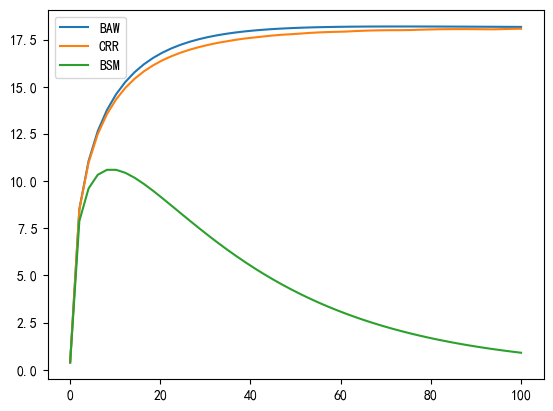

In [34]:
model_compare(T_array=np.linspace(0.01, 100, 50))  # 比较100年以内各种模型的定价

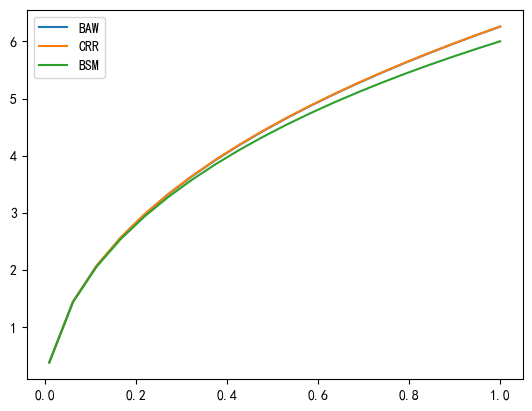

In [35]:
model_compare(T_array=np.linspace(0.01, 1, 20))  # 比较1年以内各种模型的定价

看涨期权

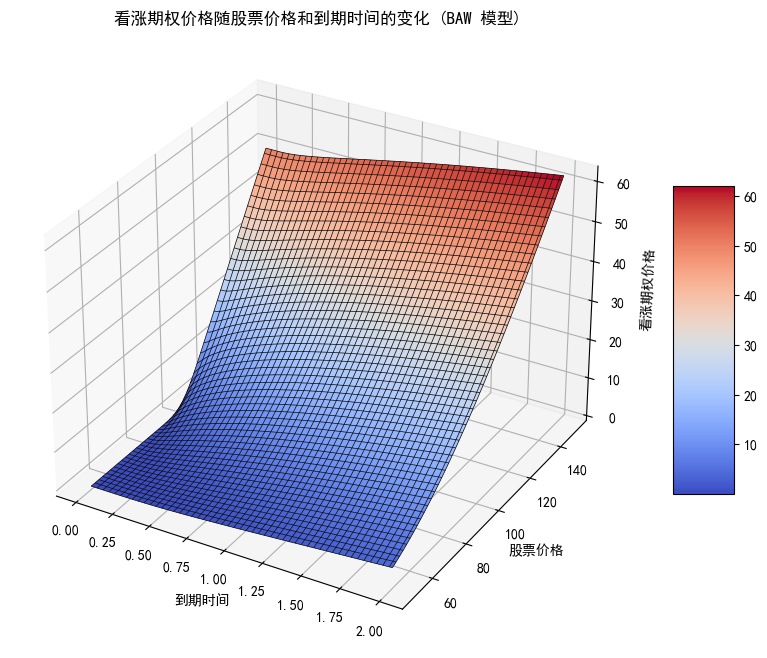

In [36]:
# 参数设置
S_array = np.linspace(50, 150, 100)  # 股票价格范围
T_array = np.linspace(0.01, 2, 100)  # 到期时间范围
X = 100  # 执行价格
sigma = 0.5  # 波动率
r = 0.03  # 无风险利率
b = 0  # 便宜收益率

# 生成网格
S_grid, T_grid = np.meshgrid(S_array, T_array)

# 计算看涨期权价格（使用BAW模型）
V_grid_C = np.array(
    [[BAW("C", S, X, sigma, T, r, b) for S in S_array] for T in T_array]
)

# 创建一个三维图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# 绘制3D曲面图
surf = ax.plot_surface(T_grid, S_grid, V_grid_C, cmap="coolwarm")
wireframe = ax.plot_wireframe(T_grid, S_grid, V_grid_C, color="black", linewidth=0.5)

fig.colorbar(surf, shrink=0.5, aspect=5)
# 设置轴标签
ax.set_ylabel("股票价格")
ax.set_xlabel("到期时间")
ax.set_zlabel("看涨期权价格")
ax.set_title("看涨期权价格随股票价格和到期时间的变化 (BAW 模型)")

plt.show()

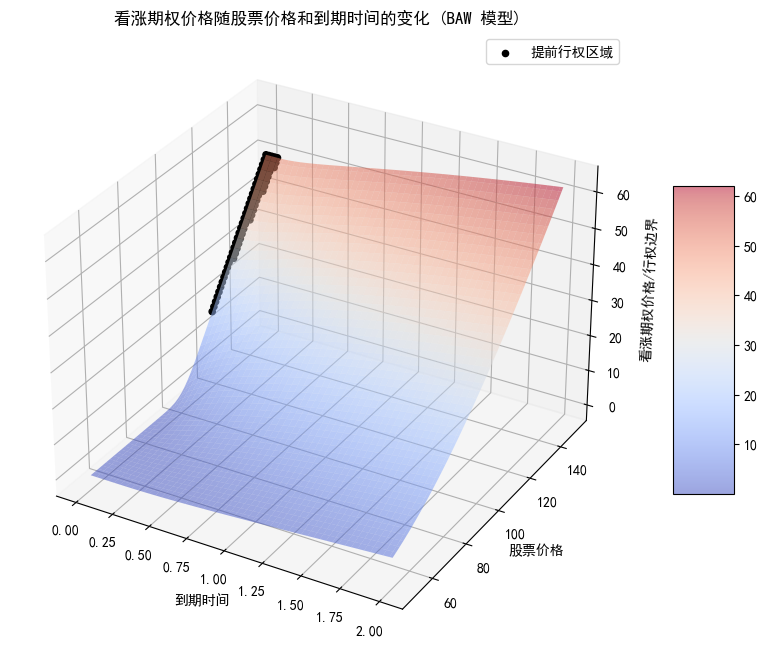

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import exp, sqrt, log

# 定义 BSM 和 BAW 函数，以及牛顿迭代法的函数（你已经提供了）

# 参数设置
S_array = np.linspace(50, 150, 100)  # 股票价格范围
T_array = np.linspace(0.01, 2, 100)  # 到期时间范围
X = 100  # 执行价格
sigma = 0.5  # 波动率
r = 0.03  # 无风险利率
b = 0  # 便宜收益率
ITERATION_MAX_ERROR = 1e-6  # 牛顿迭代法的误差阈值

# 生成网格
S_grid, T_grid = np.meshgrid(S_array, T_array)

# 计算看涨期权价格和行权边界
V_grid_C = np.array(
    [[BAW("C", S, X, sigma, T, r, b) for S in S_array] for T in T_array]
)

# 计算行权边界
S_boundary = np.array([find_Sx("C", X, sigma, T, r, b) for T in T_array])

# 创建行权边界矩阵
Boundary_grid = np.zeros_like(V_grid_C)
for i in range(len(T_array)):
    Boundary_grid[i, :] = S_boundary[i]

# 创建提前行权标记矩阵
early_exercise_mask =(S_grid > Boundary_grid)

# 创建三维图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# 绘制看涨期权价格曲面图
surf = ax.plot_surface(T_grid, S_grid, V_grid_C, cmap="coolwarm", alpha=0.5)


# 在行权边界处标注提前行权的部分
ax.scatter(
    T_grid[early_exercise_mask],
    S_grid[early_exercise_mask],
    V_grid_C[early_exercise_mask],
    color="black",
    s=20,
    label="提前行权区域",
    alpha=1
)


# 设置轴标签
ax.set_ylabel("股票价格")
ax.set_xlabel("到期时间")
ax.set_zlabel("看涨期权价格/行权边界")
ax.set_title("看涨期权价格随股票价格和到期时间的变化 (BAW 模型)")

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.legend()
plt.show()

In [38]:
# 输出部分提前行权的股票价格、到期时间、行权边界价格和期权价格
early_exercise_indices = np.where(early_exercise_mask)

print("提前行权的股票价格、到期时间、行权边界价格和期权价格:")
for idx in range(len(early_exercise_indices[0])):  
    i = early_exercise_indices[0][idx]
    j = early_exercise_indices[1][idx]
    print(
        f"股票价格: {S_grid[i, j]:.2f}, 到期时间: {T_grid[i, j]:.2f}, 行权边界价格: {Boundary_grid[i, j]:.2f}, 期权价格: {V_grid_C[i, j]:.2f}"
    )

提前行权的股票价格、到期时间、行权边界价格和期权价格:
股票价格: 117.68, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 17.68
股票价格: 118.69, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 18.69
股票价格: 119.70, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 19.70
股票价格: 120.71, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 20.71
股票价格: 121.72, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 21.72
股票价格: 122.73, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 22.73
股票价格: 123.74, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 23.74
股票价格: 124.75, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 24.75
股票价格: 125.76, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 25.76
股票价格: 126.77, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 26.77
股票价格: 127.78, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 27.78
股票价格: 128.79, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 28.79
股票价格: 129.80, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 29.80
股票价格: 130.81, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 30.81
股票价格: 131.82, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 31.82
股票价格: 132.83, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 32.83
股票价格: 133.84, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 33.84
股票价格: 134.85, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 34.85


In [39]:
# 输出未提前行权的股票价格、到期时间、行权边界价格和期权价格
early_exercise_indices = np.where(~early_exercise_mask)

print("提前行权的股票价格、到期时间、行权边界价格和期权价格:")
for idx in range(len(early_exercise_indices[0])):  
    i = early_exercise_indices[0][idx]
    j = early_exercise_indices[1][idx]
    print(
        f"股票价格: {S_grid[i, j]:.2f}, 到期时间: {T_grid[i, j]:.2f}, 行权边界价格: {Boundary_grid[i, j]:.2f}, 期权价格: {V_grid_C[i, j]:.2f}"
    )

提前行权的股票价格、到期时间、行权边界价格和期权价格:
股票价格: 50.00, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 51.01, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 52.02, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 53.03, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 54.04, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 55.05, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 56.06, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 57.07, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 58.08, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 59.09, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 60.10, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 61.11, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 62.12, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 63.13, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 64.14, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 65.15, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 66.16, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 67.17, 到期时间: 0.01, 行权边界价格: 117.19, 期权价格: 0.00
股票价格: 68.18, 到期时间: 0.01, 行权边界价格: 117

看跌期权

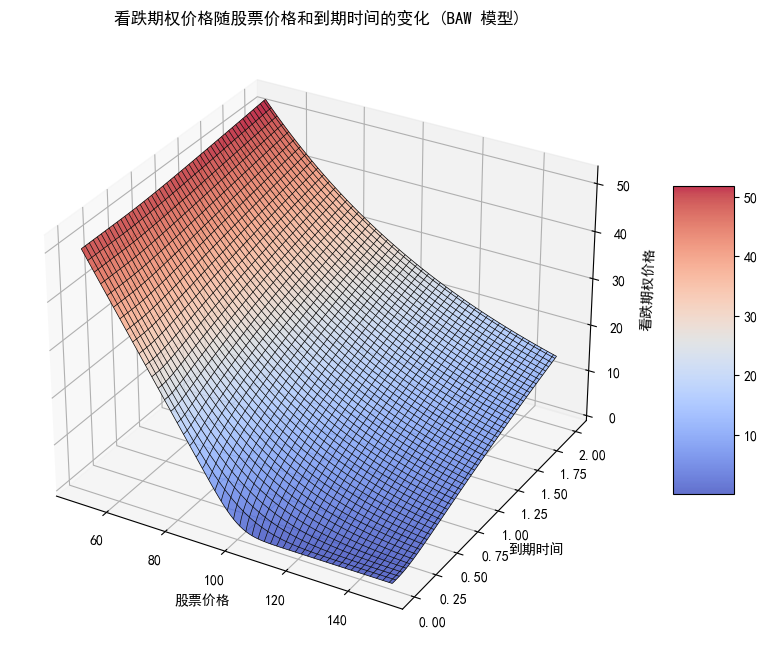

In [40]:
# 参数设置
S_array = np.linspace(50, 150, 100)  # 缩小样本数方便显示
T_array = np.linspace(0.01, 2, 100)
X = 100  # 执行价格
sigma = 0.5  # 波动率
r = 0.03  # 无风险利率
b = 0  # 便宜收益率

# 生成网格
S_grid, T_grid = np.meshgrid(S_array, T_array)

# 计算看涨期权价格
V_grid_P = np.array(
    [[BAW("P", S, X, sigma, T, r, b) for S in S_array] for T in T_array]
)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# 绘制3D曲面图
surf = ax.plot_surface(
    S_grid, T_grid, V_grid_P, cmap="coolwarm", alpha=0.8, edgecolor="none"
)
wireframe = ax.plot_wireframe(S_grid, T_grid, V_grid_P, color="black", linewidth=0.5)

fig.colorbar(surf, shrink=0.5, aspect=5)

# 设置轴标签
ax.set_xlabel("股票价格")
ax.set_ylabel("到期时间")
ax.set_zlabel("看跌期权价格")
ax.set_title("看跌期权价格随股票价格和到期时间的变化 (BAW 模型)")

plt.show()

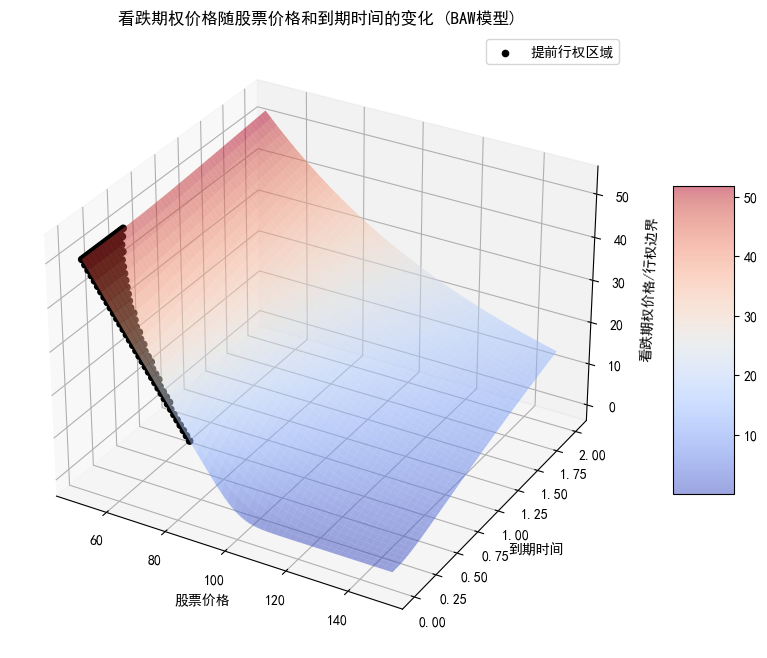

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from math import exp, sqrt, log

# 定义 BSM 和 BAW 函数，以及牛顿迭代法的函数（你已经提供了）

# 参数设置
S_array = np.linspace(50, 150, 100)  # 股票价格范围
T_array = np.linspace(0.01, 2, 100)  # 到期时间范围
X = 100  # 执行价格
sigma = 0.5  # 波动率
r = 0.03  # 无风险利率
b = 0  # 便宜收益率
ITERATION_MAX_ERROR = 1e-6  # 牛顿迭代法的误差阈值

# 生成网格
S_grid, T_grid = np.meshgrid(S_array, T_array)

# 计算看涨期权价格和行权边界
V_grid_P = np.array(
    [[BAW("P", S, X, sigma, T, r, b) for S in S_array] for T in T_array]
)

# 计算行权边界
S_boundary = np.array([find_Sx("P", X, sigma, T, r, b) for T in T_array])

# 创建行权边界矩阵
Boundary_grid = np.zeros_like(V_grid_P)
for i in range(len(T_array)):
    Boundary_grid[i, :] = S_boundary[i]

# 创建提前行权标记矩阵
early_exercise_mask = (S_grid < Boundary_grid)

# 创建三维图
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# 绘制看涨期权价格曲面图
surf = ax.plot_surface(S_grid, T_grid, V_grid_P, cmap="coolwarm", alpha=0.5)


# 在行权边界处标注提前行权的部分
ax.scatter(
    S_grid[early_exercise_mask],
    T_grid[early_exercise_mask],
    V_grid_P[early_exercise_mask],
    color="black",
    s=20,
    label="提前行权区域",
    alpha=1,
)

# 设置轴标签
ax.set_xlabel("股票价格")
ax.set_ylabel("到期时间")
ax.set_zlabel("看跌期权价格/行权边界")
ax.set_title("看跌期权价格随股票价格和到期时间的变化 (BAW模型)")

fig.colorbar(surf, shrink=0.5, aspect=5)
ax.legend()
plt.show()

In [42]:
# 输出部分提前行权的股票价格、到期时间、行权边界价格和期权价格
early_exercise_indices = np.where(early_exercise_mask)

print("提前行权的股票价格、到期时间、行权边界价格和期权价格:")
for idx in range(len(early_exercise_indices[0])):  
    i = early_exercise_indices[0][idx]
    j = early_exercise_indices[1][idx]
    print(
        f"股票价格: {S_grid[i, j]:.2f}, 到期时间: {T_grid[i, j]:.2f}, 行权边界价格: {Boundary_grid[i, j]:.2f}, 期权价格: {V_grid_P[i, j]:.2f}"
    )

提前行权的股票价格、到期时间、行权边界价格和期权价格:
股票价格: 50.00, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 50.00
股票价格: 51.01, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 48.99
股票价格: 52.02, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 47.98
股票价格: 53.03, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 46.97
股票价格: 54.04, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 45.96
股票价格: 55.05, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 44.95
股票价格: 56.06, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 43.94
股票价格: 57.07, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 42.93
股票价格: 58.08, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 41.92
股票价格: 59.09, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 40.91
股票价格: 60.10, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 39.90
股票价格: 61.11, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 38.89
股票价格: 62.12, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 37.88
股票价格: 63.13, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 36.87
股票价格: 64.14, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 35.86
股票价格: 65.15, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 34.85
股票价格: 66.16, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 33.84
股票价格: 67.17, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 32.83
股票价格: 68.18, 到期时间: 0.01, 行权边界价格: 85.

In [43]:
# 获取未提前行权的位置
non_early_exercise_indices = np.where(~early_exercise_mask)

print("未提前行权的股票价格、到期时间、行权边界价格和期权价格:")
for idx in range(len(non_early_exercise_indices[0])):  
    i = non_early_exercise_indices[0][idx]
    j = non_early_exercise_indices[1][idx]
    print(
        f"股票价格: {S_grid[i, j]:.2f}, 到期时间: {T_grid[i, j]:.2f}, 行权边界价格: {Boundary_grid[i, j]:.2f}, 期权价格: {V_grid_P[i, j]:.2f}"
    )

未提前行权的股票价格、到期时间、行权边界价格和期权价格:
股票价格: 85.35, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 14.65
股票价格: 86.36, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 13.64
股票价格: 87.37, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 12.63
股票价格: 88.38, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 11.62
股票价格: 89.39, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 10.62
股票价格: 90.40, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 9.63
股票价格: 91.41, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 8.65
股票价格: 92.42, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 7.69
股票价格: 93.43, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 6.76
股票价格: 94.44, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 5.86
股票价格: 95.45, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 5.01
股票价格: 96.46, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 4.21
股票价格: 97.47, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 3.48
股票价格: 98.48, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 2.83
股票价格: 99.49, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 2.25
股票价格: 100.51, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 1.76
股票价格: 101.52, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 1.34
股票价格: 102.53, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格: 1.00
股票价格: 103.54, 到期时间: 0.01, 行权边界价格: 85.33, 期权价格